In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [2]:
D = np.load('drifting_gratings_data.npz')
binned_spikes = D['binned_spikes']
stim = D['stim_array']
CCmaxs = D['CCmaxs']
bin_len = 0.01

D = np.load('cell_types71.npz')
cell_types = D['cell_types']

In [3]:
ord_idxs = np.argsort(CCmaxs)[-30:]
ord_idxs = np.concatenate((ord_idxs[:-12],ord_idxs[-11:-6],ord_idxs[-5:]))
ord_types = cell_types[ord_idxs]
print np.unique(cell_types[ord_idxs],return_counts=True)
print CCmaxs[ord_idxs[-1]]

(array(['exc_VISp_1', 'exc_VISp_5', 'inh_VISp_1', 'inh_VISp_4',
       'inh_VISp_5'], dtype='|S10'), array([ 3,  3,  4,  2, 16]))
0.9199474554408273


In [51]:
#helper functions for fitting GLM models
from scipy.stats import pearsonr

def construct_Xdsn(flat_stimulus, binned_spikes, d):
    T = binned_spikes.size # T is number of time bins
    (M,T1) = flat_stimulus.shape # M is the size of a stimulus
    
    assert T==T1, "arrays have different number of time samples"
    d1,d2 = d
    dmax = max(d)
    binned_spikes = np.concatenate((np.zeros((dmax,)),binned_spikes))
    flat_stimulus = np.concatenate((np.zeros((M,dmax)),flat_stimulus),axis=1)
    T = binned_spikes.size
    X_dsn = np.ones((T-dmax,M*d1+d2+1))
    for t in range(T-dmax):
        X_dsn[t,:M*d1] = flat_stimulus[:,t+dmax+1-d1:t+dmax+1].reshape((1,-1))  #stimulus inputs
        X_dsn[t,M*d1:-1] = np.flip(binned_spikes[t+dmax-d2:t+dmax],axis=0).reshape((1,-1)) #spike inputs
    return X_dsn

def fit_GLM(stim,spks,d,val_stim=None,val_spks=None):
    d1,d2 = d
    dmax = max(d)
    model =  sm.GLM(spks.reshape([-1,1]),construct_Xdsn(stim,spks,d),family = sm.families.Poisson())
    model_results = model.fit()
    p = model_results.params
    se = model_results.bse
    b = p[-1]
    bse = se[-1]
    stim_filt = p[:-1-d2]
    stim_se = se[:-1-d2]
    spk_filt = p[-1-d2:-1]
    spk_se = se[-1-d2:-1]
    
    t_filt = np.arange(-6,7)
    sig = 1.5
    filt = np.exp(-np.square(t_filt)/(sig**2*2))
    filt = filt/np.sum(filt)
    
    train_nnll = -model_results.llf/(spks.shape[-1]-dmax)
    smooth_spks = np.convolve(spks,filt,mode='same')
    train_corr = pearsonr(model.predict(p),smooth_spks)[0]
    if val_stim is not None:
        val_model = sm.GLM(val_spks.reshape([-1,1]),construct_Xdsn(val_stim,val_spks,d),family = sm.families.Poisson())
        val_nnll = -val_model.loglike(p)/(spks.shape[-1]-dmax)
        smooth_val_spks = np.convolve(val_spks,filt,mode='same')
        val_corr = pearsonr(model.predict(p),smooth_val_spks)[0]
        return stim_filt, spk_filt, b, stim_se, spk_se, bse, train_nnll, train_corr, val_nnll, val_corr
    return stim_filt, spk_filt, b, stim_se, spk_se, bse, train_nnll, train_corr



In [20]:
conds = np.unique(stim,axis=1)  
mod_stim = np.zeros((conds.shape[1],stim.shape[1]))
for t in range(stim.shape[1]):
    ind = np.argwhere(np.all(stim[:,t:t+1]-conds==0,axis=0))
    mod_stim[ind,t] = 1

In [29]:
# st = np.concatenate((np.zeros((mod_stim.shape[0],1)),np.diff(mod_stim,axis=1)),axis=1)>0
# print st.shape, binned_spikes.shape

K = 3 # number of harmonics
L = 2*K+1
conds = np.unique(stim,axis=1)  
mod_stim_sin = np.zeros((L*(conds.shape[1]-1),stim.shape[1]))
ind_old = -1
for t in range(stim.shape[1]):
    if stim[0,t]>0:
        ind = np.argwhere(np.all(stim[:,t:t+1]-conds==0,axis=0))
        if ind!=ind_old:
            t0=t
            ind_old=ind
        mod_stim_sin[(ind-1)*L,t] = 1
        for k in range(K):
            mod_stim_sin[(ind-1)*L+2*k+1,t] = np.cos(2.0*np.pi*(k+1)*stim[0,t]*(t-t0)*bin_len)
            mod_stim_sin[(ind-1)*L+2*k+2,t] = np.sin(2.0*np.pi*(k+1)*stim[0,t]*(t-t0)*bin_len)
        
    else:
        ind_old = -1

In [58]:
mod_stim_start = np.concatenate((np.zeros((mod_stim.shape[0],1)),np.diff(mod_stim,axis=1)),axis=1)>0

(-0.5, 380616.5, 279.5, -0.5)

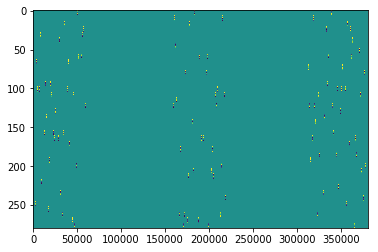

In [14]:
# # print np.unique(mod_stim_sin)
# x = np.hstack((mod_stim[:,:64000],mod_stim[:,156000:224000],mod_stim[:,316000:]))
# # plt.imshow(x,cmap='Greys')
plt.imshow(mod_stim_sin)
plt.axis('tight')

In [31]:
A = np.arange(8).reshape(2,4)
print A, A.T.reshape(1,-1)

[[0 1 2 3]
 [4 5 6 7]] [[0 4 1 5 2 6 3 7]]


In [ ]:
d = [200,30]
# stim_filt, spk_filt, b, stim_se, spk_se, bse = fit_GLM(mod_stim/np.sum(mod_stim,axis=1,keepdims=True),np.expand_dims(binned_spikes[-1,:],0),d)
stim_filt, spk_filt, b, stim_se, spk_se, bse, nnll, corr = fit_GLM(mod_stim_start[:,:60000],binned_spikes[ord_idxs[-1],:60000],d)


0.3408264780266385 0.46696208954777746 -2.7532362896759888 0.008321719220741826


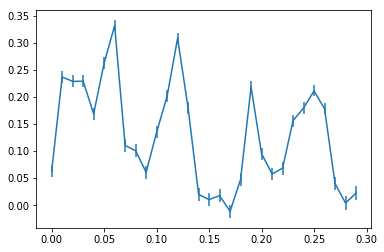

In [57]:
plt.errorbar(np.arange(d[1])*bin_len,spk_filt,yerr=spk_se)
# plt.ylim([-1,1])
print nnll,corr,b, bse

2.2693186106475842 0.07215660171059608


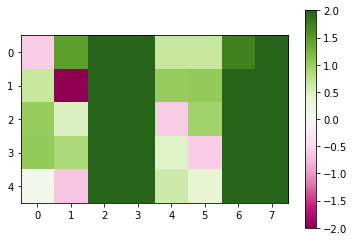

In [28]:
print stim_filt[0], stim_se[0]
plt.imshow(stim_filt[1:].reshape(5,8),cmap='PiYG',vmin=-2,vmax=2)
# print stim_filt[-1], stim_se[-1]
# plt.imshow(np.sqrt(np.square(stim_filt[0:-1:2])+np.square(stim_filt[1:-1:2])).reshape(5,8))
plt.colorbar()

# plt.errorbar(np.arange(stim_filt.size),stim_filt,yerr=stim_se)

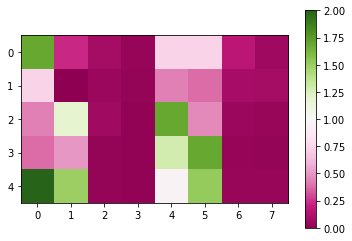

In [26]:
plt.imshow((stim_se[1:]/np.abs(stim_filt[1:])).reshape(5,8), vmin=0, vmax=2,cmap='PiYG')
# plt.imshow(np.sqrt(np.square(stim_se[0:-1:2])+np.square(stim_se[1:-1:2])).reshape(5,8))
plt.colorbar()

In [ ]:
import gc
split_ind = 280000#-5000
# train_nnlls = []
# val_nnlls = []
for idx in ord_idxs[-30+19:]:
    stim_filt, spk_filt, b, stim_se, spk_se, bse, train_nnll = fit_GLM(mod_stim[:,:split_ind]/100,np.expand_dims(binned_spikes[idx,:split_ind],0),d)
    train_nnlls.append(train_nnll)
    val_nnll = val_GLM(mod_stim[:,split_ind:]/100,np.expand_dims(binned_spikes[idx,split_ind:],0),d,stim_filt, spk_filt, b)
    val_nnlls.append(val_nnll)
    print len(val_nnlls)
    gc.collect()
    

19
20
21
22
23
24


In [ ]:
lims = [0,1]
plt.plot(val_nnlls,train_nnlls,'o')
plt.plot(lims,lims)
plt.axis('square')
plt.xlim(lims)
plt.ylim(lims)


In [ ]:
np.savez('drifting_gratings_indivfit1',train_nnlls = np.array(train_nnlls), val_nnlls = np.array(val_nnlls))